In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.feature_selection import VarianceThreshold
import random
import pickle
from sklearn.preprocessing import StandardScaler
import os
import tensorflow as tf
from tqdm.notebook import tqdm
from scipy.stats import multivariate_normal as mvn
import matplotlib.pyplot as plt
from scipy.linalg import block_diag
import warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

2023-07-13 22:51:10.359894: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-13 22:51:10.406096: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-13 22:51:10.636326: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-13 22:51:10.637864: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-13 22:51:11.959313: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
warnings.filterwarnings('ignore')

In [3]:
def get_targets_with_weights(batch_data, initial_ensembles, size_ens): 
    
    target_dim = 1
    
    # weights_ann_1 = ann.get_weights()
    
    # h1  = ann.layers[1].output.shape[-1]

    n_hidden_1 = len(weights_ann_1[0].ravel())
    
    hidden_weights_1 = initial_ensembles[:,:n_hidden_1].reshape( size_ens, batch_data.shape[1], h1)
    
    
    hidden_output_1 = np.einsum('ij,kjl->kil', batch_data, hidden_weights_1)

    
    hidden_layer_bias_1 = initial_ensembles[:,n_hidden_1:(n_hidden_1 + h1)].reshape(size_ens, 1,  h1)


    hidden_output_1 = hidden_output_1 + hidden_layer_bias_1

    n_pred_weights_1 = len(weights_ann_1[2].ravel())

    output_weights_1 = initial_ensembles[:,(n_hidden_1 + h1):(n_hidden_1 + h1 + n_pred_weights_1) ].reshape(size_ens, h1, target_dim)


    output_1 = np.einsum('ijk,ikl->ijl', hidden_output_1, output_weights_1)


    output_layer_bias_1 = initial_ensembles[:,(n_hidden_1 + h1 + n_pred_weights_1):(n_hidden_1 + h1 + n_pred_weights_1 + target_dim)].reshape(size_ens, 1, target_dim)


    final_output_1 = output_1 + output_layer_bias_1
    
    final_output_1 = final_output_1[:,:, 0]
    
    # print(final_output_1.shape, initial_ensembles.shape)
    
    stack = np.hstack((final_output_1, initial_ensembles))

    
    return final_output_1, stack

In [4]:
def ann(hidden = 32, input_shape = 256, output_shape = 1): 
    input_layer = tf.keras.layers.Input(shape = (input_shape))
    hidden_layer = tf.keras.layers.Dense(hidden)
    hidden_output = hidden_layer(input_layer)
    pred_layer = tf.keras.layers.Dense(output_shape, activation = "relu")
    pred_output = pred_layer(hidden_output)
#     pred_output = tf.keras.layers.Activation("softmax")(pred_output)
    model = tf.keras.models.Model(input_layer, pred_output)
    return model

In [5]:
def generate_initial_ensembles(num_weights, lambda1, size_ens):
    mean_vec = np.zeros((num_weights,))
    cov_matrix = lambda1*np.identity(num_weights)
    mvn_samp = mvn(mean_vec, cov_matrix)
    return mvn_samp.rvs(size_ens)

In [6]:
def expit(x):
    """Compute softmax values for each sets of scores in x."""
#     e_x = np.exp(x - np.max(x))
    return 1 / (1 + np.exp(-x))

In [7]:
samp_ann =  ann(hidden = 16, input_shape = 32, output_shape = 1)

In [8]:
weights_ann_1 = samp_ann.get_weights()

In [9]:
h1  = samp_ann.layers[1].output.shape[-1]

In [10]:
samp_ann.count_params()

545

In [11]:
hidden_neurons = h1

In [12]:
samp_ann_params = samp_ann.count_params()

In [13]:
def get_initial_X_t(data1, data2, size_ens, var_weights = 1.0, var_weight_weights = 4.0, var_L = 1.0, var_D = 1.0):
    # samp_ann =  ann(hidden = hidden_neurons, input_shape = 32, output_shape = 1)
    
    initial_ensembles1 = generate_initial_ensembles(samp_ann_params, var_weights, size_ens)
    data1_out1, data1_stack1 = get_targets_with_weights(data1, initial_ensembles1, size_ens = size_ens)
    
    initial_ensembles2 = generate_initial_ensembles(samp_ann_params, var_weights, size_ens)
    data1_out2, data1_stack2 = get_targets_with_weights(data1, initial_ensembles2, size_ens = size_ens)
    
    initial_ensembles3 = generate_initial_ensembles(samp_ann_params, var_weights, size_ens)
    data2_out1, data2_stack1 = get_targets_with_weights(data2, initial_ensembles3, size_ens = size_ens)
    
    initial_ensembles4 = generate_initial_ensembles(samp_ann_params, var_weights, size_ens)
    data2_out2, data2_stack2 = get_targets_with_weights(data2, initial_ensembles4, size_ens = size_ens)   
    
    X_t = np.concatenate((np.expand_dims(data1_stack1, -1), np.expand_dims(data1_stack2, -1), 
                         np.expand_dims(data2_stack1, -1), np.expand_dims(data2_stack2, -1)), axis = -1)
    
    initial_ensembles_for_weights = generate_initial_ensembles(4, var_weight_weights, size_ens)
    initial_ensembles_for_weights = np.expand_dims(initial_ensembles_for_weights,1)
    
    initial_ensembles_for_L = generate_initial_ensembles(4, var_L, size_ens)
    initial_ensembles_for_L = np.expand_dims(initial_ensembles_for_L,1)    
    
    initial_ensembles_for_D1 = generate_initial_ensembles(1, var_D, size_ens).reshape(-1,1)
    initial_ensembles_for_D2 = generate_initial_ensembles(1, var_D, size_ens).reshape(-1,1)
    
    initial_ensembles_for_D1_zero = np.zeros((size_ens,1,1)).reshape(-1,1)
    initial_ensembles_for_D2_zero = np.zeros((size_ens,1,1)).reshape(-1,1)
    
    initial_ensembles_for_D = np.concatenate((np.expand_dims(initial_ensembles_for_D1,1),
                                                       np.expand_dims(initial_ensembles_for_D1_zero,1), 
                                                      np.expand_dims(initial_ensembles_for_D2,1),
                                                       np.expand_dims(initial_ensembles_for_D2_zero,1)), axis = 2)
    
    # print(X_t.shape, initial_ensembles_for_weights.shape)
    
    X_t = np.concatenate((X_t, initial_ensembles_for_weights, initial_ensembles_for_L, initial_ensembles_for_D), axis = 1)
    
    initial_ensembles = np.hstack((initial_ensembles1, initial_ensembles2, initial_ensembles3, initial_ensembles4))
    
    return X_t, initial_ensembles, initial_ensembles_for_weights[:,0,:], initial_ensembles_for_L[:,0,:], initial_ensembles_for_D[:,0,:]

In [14]:
def get_weighted_targets_with_weights(batch_data, initial_ensembles, size_ens, weights): 
    
    target_dim = 1
    

    n_hidden_1 = len(weights_ann_1[0].ravel())
    
    hidden_weights_1 = initial_ensembles[:,:n_hidden_1].reshape( size_ens, batch_data.shape[1], h1)
    
    
    hidden_output_1 = np.einsum('ij,kjl->kil', batch_data, hidden_weights_1)

    
    hidden_layer_bias_1 = initial_ensembles[:,n_hidden_1:(n_hidden_1 + h1)].reshape(size_ens, 1,  h1)


    hidden_output_1 = hidden_output_1 + hidden_layer_bias_1

    n_pred_weights_1 = len(weights_ann_1[2].ravel())

    output_weights_1 = initial_ensembles[:,(n_hidden_1 + h1):(n_hidden_1 + h1 + n_pred_weights_1) ].reshape(size_ens, h1, target_dim)


    output_1 = np.einsum('ijk,ikl->ijl', hidden_output_1, output_weights_1)


    output_layer_bias_1 = initial_ensembles[:,(n_hidden_1 + h1 + n_pred_weights_1):(n_hidden_1 + h1 + n_pred_weights_1 + target_dim)].reshape(size_ens, 1, target_dim)


    final_output_1 = output_1 + output_layer_bias_1
    
    final_output_1 = final_output_1[:,:, 0]
    
    final_output_1 = final_output_1*weights
    
    # print(final_output_1.shape, initial_ensembles.shape)
    
    stack = np.hstack((final_output_1, initial_ensembles))

    
    return final_output_1, stack

In [15]:
std_targets = pickle.load( open('..//Data//target_scaler.pkl', 'rb'))

In [16]:
from scipy.stats import beta

In [17]:
fudging_beta = beta(1,9)

In [18]:
def forward_operation(data1, data2, combined_ensembles , size_ens, fudging_beta):
    # samp_ann =  ann(hidden = hidden_neurons, input_shape = 32, output_shape = 1)
    params = samp_ann_params
    initial_ensembles1 = combined_ensembles[:, :params]
    initial_ensembles2 = combined_ensembles[:, params:(2*params)]
    initial_ensembles3 = combined_ensembles[:, (2*params):(3*params)]
    initial_ensembles4 = combined_ensembles[:, (3*params):(4*params)]

    
    initial_ensembles_for_weights = combined_ensembles[:, (4*params):(4*params + 4)]
    
    initial_ensembles_for_L = combined_ensembles[:, (4*params + 4):(4*params + 4 + 4)]
    
    initial_ensembles_for_D = combined_ensembles[:,(4*params + 4 + 4):(4*params + 4 + 4 + 4)]
    
    
    softmax_weights = tf.math.softmax(initial_ensembles_for_weights).numpy()
    
    model_1 = softmax_weights[:, :2].sum(1).reshape(-1,1) +  fudging_beta.rvs(size_ens).reshape(-1,1)
    
    # model_1 = np.min(model_1 -fudging_factor)
    
    model_2 = softmax_weights[:, 2:].sum(1).reshape(-1,1) +  fudging_beta.rvs(size_ens).reshape(-1,1)
    
    
    model_1_plus_model_2 = model_1 + model_2
    
    model_1 = model_1/model_1_plus_model_2
    
    model_2 = model_2/model_1_plus_model_2
    
    
    # print(np.mean(model_1 + model_2))
    
    data1_out1, data1_stack1 = get_weighted_targets_with_weights(data1, initial_ensembles1, size_ens = size_ens,
                                                                  weights=model_1)
    
    data1_out2, data1_stack2 = get_weighted_targets_with_weights(data1, initial_ensembles2, size_ens = size_ens,
                                                                weights=model_1)
    
    data2_out1, data2_stack1 = get_weighted_targets_with_weights(data2, initial_ensembles3, size_ens = size_ens,
                                                                 weights=model_2)
    
    data2_out2, data2_stack2 = get_weighted_targets_with_weights(data2, initial_ensembles4, size_ens = size_ens,
                                                                  weights=model_2)   
    
    X_t = np.concatenate((np.expand_dims(data1_stack1, -1), np.expand_dims(data1_stack2, -1), 
                         np.expand_dims(data2_stack1, -1), np.expand_dims(data2_stack2, -1)), axis = -1)
    
    initial_ensembles = np.hstack((initial_ensembles1, initial_ensembles2, initial_ensembles3, initial_ensembles4, 
                        initial_ensembles_for_weights, initial_ensembles_for_L, initial_ensembles_for_D))
    
    # print(X_t.shape)
    
    initial_ensembles_for_weights = np.expand_dims(initial_ensembles_for_weights,1)
    
    initial_ensembles_for_L = np.expand_dims(initial_ensembles_for_L,1)
    
    initial_ensembles_for_D = np.expand_dims(initial_ensembles_for_D,1)
    
    # print(initial_ensembles_for_weights.shape)
    
    X_t = np.concatenate((X_t, initial_ensembles_for_weights, initial_ensembles_for_L, initial_ensembles_for_D), axis = 1)
    
    weighted_alogp = data1_out1 + data2_out1
    
    weighted_psa = data1_out2 + data2_out2
    
    return X_t, initial_ensembles, weighted_alogp, weighted_psa, model_1, model_2, data1_out1, data1_out2, data2_out1, data2_out2

In [19]:
total_weights = 4*(samp_ann.count_params() + 1 + 1 + 1)

In [20]:
reduction = 10

In [21]:
size_ens = total_weights//reduction

In [22]:
size_ens

219

In [23]:
G_t = [[1, 0, 1, 0], [0, 1, 0, 1]]
G_t = np.array(G_t).T

In [24]:
def get_predictions(data1, data2, initial_ensembles, fudging_beta  =fudging_beta): 
    _,_, weighted_alogp, weighted_psa, w1, w2, data1_out1, data1_out2, data2_out1, data2_out2 = forward_operation(data1, data2, initial_ensembles, size_ens = size_ens, fudging_beta = fudging_beta)
    weighted_alogp = np.expand_dims(weighted_alogp,-1)
    weighted_psa = np.expand_dims(weighted_psa,-1)
    preds = np.concatenate((weighted_alogp, weighted_psa),-1)
    
    weighted_smiles_alogp = np.expand_dims(data1_out1,-1)
    weighted_smiles_psa = np.expand_dims(data1_out2,-1)
    weighted_smiles_preds = np.concatenate((weighted_smiles_alogp, weighted_smiles_psa),-1)

    weighted_rdkit_alogp = np.expand_dims(data2_out1,-1)
    weighted_rdkit_psa = np.expand_dims(data2_out2,-1)
    weighted_rdkit_preds = np.concatenate((weighted_rdkit_alogp, weighted_rdkit_psa),-1)
    
    return preds, w1, w2, weighted_smiles_preds, weighted_rdkit_preds

In [25]:
def get_predictions_test(data1, data2, initial_ensembles): 
    _,_, weighted_alogp, weighted_psa, w1, w2 = forward_operation_test(data1, data2, initial_ensembles, size_ens = size_ens)
    weighted_alogp = np.expand_dims(weighted_alogp,-1)
    weighted_psa = np.expand_dims(weighted_psa,-1)
    preds = np.concatenate((weighted_alogp, weighted_psa),-1)
    return preds, w1, w2

In [26]:
def calculate_mu_bar_G_bar(data1, data2, initial_ensembles, fudging_beta):
    H_t = np.hstack((np.identity(data1.shape[0]), np.zeros((data1.shape[0], samp_ann_params + 1 + 1 + 1))))
    mu_bar = initial_ensembles.mean(0)
    X_t,_, _, _, _, _, _, _, _, _ = forward_operation(data1, data2, initial_ensembles, size_ens = size_ens, fudging_beta = fudging_beta)
    X_t = X_t.transpose((0,2,1))
    X_t = X_t.reshape(X_t.shape[0], X_t.shape[1]*X_t.shape[2])
    script_H_t = np.kron(G_t.T, H_t)
    G_u = (script_H_t@X_t.T)
    G_u = G_u.T
    G_bar = (G_u.mean(0)).ravel()
    return mu_bar.reshape(-1,1), G_bar.reshape(-1,1), G_u

In [27]:
def calculate_C_u(initial_ensembles, mu_bar, G_bar, G_u): 
    u_j_minus_u_bar = initial_ensembles - mu_bar.reshape(1,-1)
    G_u_minus_G_bar = G_u -  G_bar.reshape(1,-1)
    c = np.zeros((total_weights, G_bar.shape[0]))
    for i in range(0, size_ens): 
        c += np.kron(u_j_minus_u_bar[i, :].T.reshape(-1,1), G_u_minus_G_bar[i,:].reshape(-1,1).T)
    return c/size_ens, G_u_minus_G_bar

In [28]:
def calculate_D_u( G_bar, G_u): 
    G_u_minus_G_bar = G_u -  G_bar.reshape(1,-1)
    d = np.zeros((G_bar.shape[0], G_bar.shape[0]))
    for i in range(0, size_ens): 
        d += np.kron(G_u_minus_G_bar[i,:].T.reshape(-1,1), G_u_minus_G_bar[i,:].reshape(-1,1).T)
    return d/size_ens

In [29]:
def get_updated_ensemble(data1, data2, initial_ensembles, y_train, size_ens = size_ens, inflation_factor = 1.0, fudging_beta = fudging_beta, fudging_var = 1.0):
    mu_bar, G_bar, G_u = calculate_mu_bar_G_bar(data1, data2, initial_ensembles, fudging_beta)
    C, G_u_minus_G_bar = calculate_C_u(initial_ensembles, mu_bar, G_bar, G_u)
    D = calculate_D_u( G_bar, G_u)
    _, R_t = create_cov(data1.shape[0],initial_ensembles)
    inflation = np.identity(R_t.shape[0])*inflation_factor
    D_plus_cov = D + (R_t *inflation_factor)
    D_plus_cov_inv = np.linalg.inv(D_plus_cov)
    mid_quant = C@D_plus_cov_inv
    noise_vec_mean = np.zeros((R_t.shape[0], ))
    noise_mvn = mvn(noise_vec_mean, R_t)
    fudging = noise_mvn.rvs(size_ens)
    interim = (y_train.T.flatten().reshape(1,-1) + fudging)
    right_quant = interim - G_u
    mid_times_right = mid_quant@right_quant.T
    updated_ensemble = (initial_ensembles + mid_times_right.T)
    
    if fudging_var is not None: 
        mean_vec = np.zeros((updated_ensemble.shape[1],))
        cov_mat = np.identity(updated_ensemble.shape[1])*fudging_var
        fudging_for_updated_ensembles = mvn(mean_vec, cov_mat)
        fudging_for_updated_ensembles_vec = fudging_for_updated_ensembles.rvs(size_ens)
        updated_ensemble = updated_ensemble + fudging_for_updated_ensembles_vec
    return updated_ensemble

In [30]:
target_dim = 2

In [31]:
lambda_D = 1

In [32]:
def inverse_transform(data, idx):
    data_cur = data[idx, :, :]
    inv_data_cur = std_targets.inverse_transform(data_cur)
    return inv_data_cur

In [33]:
from joblib import Parallel, delayed

In [34]:
def create_cov(shape, initial_ensembles):
    cov_part = initial_ensembles[:, -8:-4]
    cov_part = cov_part.mean(0)
    # variances = tf.math.softplus(cov_part[:2]).numpy()
    variances = cov_part[:2]
    covariances = cov_part[2:]
    base_cov = np.identity(target_dim)
    base_cov[0,0] = variances[0]
    base_cov[1,1] = variances[1]
    base_cov[0,1] = covariances[0]
    base_cov[1,0] = covariances[1]
    
    variances1 = tf.math.softplus(initial_ensembles[:, -4:]).numpy()
    variances1 = variances1.mean(0)
    base_variances = np.identity(target_dim)
    base_variances[0,0] = variances1[0]
    base_variances[1,1] = variances1[2]
    
    final = np.linalg.cholesky(base_cov@base_cov.T + base_variances)
    cov_mat = final@final.T
    cov_mat_final = cov_mat
    # cov_mat_final = cov_mat@cov_mat.T
    
    if is_pos_def(cov_mat_final) != True:
        print("resulting cov matrix is not positive semi definite")
        pass
    
    # print(np.linalg.det(cov_mat_final))
    
    var1 = cov_mat_final[0,0]
    var2 = cov_mat_final[1,1]
    cov = cov_mat_final[1,0]

    n = shape
    
    ul = var1*np.identity(n)
    lr = var2*np.identity(n)
    ur = cov*np.identity(n)
    ll = ur.T    
    
    first_row = np.hstack((ul, ur))
    second_row = np.hstack((ll, lr))
    
    R_t = np.vstack((first_row, second_row))
    
    return cov_mat_final, R_t
    

In [35]:
def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)

In [36]:
with open("..//Data/smiles_70_catch.pickle", "rb") as f: 
    smiles_heavy_catch = pickle.load(f)

In [37]:
with open("..//Data/rdkit_60_catch.pickle", "rb") as f: 
    rdkit_heavy_catch = pickle.load(f)

In [38]:
catch = [ smiles_heavy_catch, rdkit_heavy_catch]

In [39]:
def prepare_data(idx, var_weights = 1.0, var_weight_weights = 4.0, var_L = 1.0, var_D = 1.0): 
    catch_idx = catch[idx]

    y_train_actual, y_train = catch_idx[2], catch_idx[3]

    smiles_feats_train = catch_idx[0]
    rdkit_feats_train = catch_idx[1]


    X_t, initial_ensembles, initial_ensembles_for_weights, initial_ensembles_for_L, initial_ensembles_for_D = get_initial_X_t(smiles_feats_train, rdkit_feats_train, size_ens = size_ens, var_weights = var_weights, var_weight_weights = var_weight_weights, var_L = var_L, var_D = var_D)
    initial_ensembles = np.hstack((initial_ensembles, initial_ensembles_for_weights, initial_ensembles_for_L, initial_ensembles_for_D))
    
    return smiles_feats_train, rdkit_feats_train, y_train, y_train_actual, initial_ensembles 

In [40]:
# catch_covs

In [41]:
from scipy.linalg import norm

In [42]:
def get_results(idx, var_weights = 1.0, var_weight_weights = 1.0, var_L = 1, var_D = 0.01, inflation_factor = 1.6, fudging_beta = beta(1,19), initial = False, previous_initial_ensembles = None, threshold = 0.98, epochs = 200, fudging_var = 1.0):
    # print('var_weights' + str(var_weights))
    # print('inflation_factor' + str(inflation_factor))
    # print('var_weight_weights' + str(var_weight_weights))
    weight_catch = []
    ratio_catch = []
    smiles_feats_train, rdkit_feats_train, y_train, y_train_actual, initial_ensembles  = prepare_data(idx, var_weights = var_weights, var_weight_weights =var_weight_weights, var_L = var_L, var_D = var_D)
    # print(R_t.shape)
    if initial == True: 
        initial_ensembles = previous_initial_ensembles
    best_train_width_mean = 100000
    # print(catch_covs[idx])
    for i in range(0,epochs):
        print("epoch number: ", str(i))
        # print("\n")
    
        # c = np.zeros((2,2))
        initial_ensembles = get_updated_ensemble(smiles_feats_train, rdkit_feats_train, initial_ensembles, y_train, size_ens, inflation_factor = inflation_factor, fudging_beta = fudging_beta, fudging_var = fudging_var)
        # print(inflation_factor)
        G_u_train, w1, w2, weighted_smiles_preds, weighted_rdkit_preds = get_predictions(smiles_feats_train, rdkit_feats_train, initial_ensembles, fudging_beta)
        
        rmse_train = np.sqrt(((y_train_actual -G_u_train.mean(0))**2).mean(0))
        
        # print("std targets rmse")
        # print(rmse_train)
        
        
        # G_u_train, w1, w2 = get_predictions_test(smiles_feats_train, rdkit_feats_train, initial_ensembles, fudging_beta)

        catch = Parallel(n_jobs = 15, verbose = 0)(delayed(inverse_transform)(G_u_train, i)  for i in range(G_u_train.shape[0]))
        G_u_train = np.array(catch)
    
        y_train_cur = std_targets.inverse_transform(y_train_actual)
    
        li_train = np.percentile(G_u_train, axis = 0, q = (2.5, 97.5))[0,:,:]   
        ui_train = np.percentile(G_u_train, axis = 0, q = (2.5, 97.5))[1,:,:]
    
        width_train = ui_train - li_train
        avg_width_train = width_train.mean(0)
    
        ind_train = (y_train_cur >= li_train) & (y_train_cur <= ui_train)
        coverage_train= ind_train.mean(0)
    
        averaged_targets_train = G_u_train.mean(0)
        rmse_train = np.sqrt(((y_train_cur -averaged_targets_train)**2).mean(0))

        cov_mat_final, _ = create_cov(smiles_feats_train.shape[0],initial_ensembles)

        # est_r =  correlation_from_covariance(cov_mat_final)

        
        li_smiles_weight = np.percentile(w1, axis = 0, q = (2.5, 97.5))[0][0]
        
        # print(np.percentile(w1, axis = 0, q = (2.5, 97.5)))
        
        ui_smiles_weight = np.percentile(w1, axis = 0, q = (2.5, 97.5))[1][0]      
        
        print("Coverages, CI Widths, RMSEs")
        print(coverage_train.tolist(), avg_width_train.tolist(), rmse_train.tolist())
        # print("\n")
        # # print(coverage_test.tolist(), avg_width_test.tolist(), rmse_test.tolist())
        print("Smiles Weight Mean and Std Dev")
        print(w1.mean(), w1.std())
        # print("\n")
        print("Smiles Weight CI")
        print(li_smiles_weight, ui_smiles_weight)
        # print("\n")
        # print(avg_width_train.tolist(), coverage_train.tolist(), rmse_train.tolist(), avg_width_test.tolist(), coverage_test.tolist(), rmse_test.tolist(), w1.mean())
        
        weight_catch.append(w1.mean())
        
        rmse_train = np.sqrt(((y_train_actual -weighted_smiles_preds.mean(0))**2).mean(0))
        
        # print("smiles std targets rmse")
        # print(rmse_train)
        catch_smiles = Parallel(n_jobs = 15, verbose = 0)(delayed(inverse_transform)(weighted_smiles_preds, i)  for i in range(weighted_smiles_preds.shape[0]))
        
        catch_smiles = np.array(catch_smiles)

        rmse_train = np.sqrt(((y_train_actual -weighted_rdkit_preds.mean(0))**2).mean(0))
        
        # print("rdkit std targets rmse")
        # print(rmse_train)
        
        catch_rdkit = Parallel(n_jobs = 15, verbose = 0)(delayed(inverse_transform)(weighted_rdkit_preds, i)  for i in range(weighted_rdkit_preds.shape[0]))
        
        catch_rdkit = np.array(catch_rdkit)
        
        averaged_smiles_preds_train = catch_smiles.mean(0)
        
        rmse_smiles_train_weighted = np.sqrt(((y_train_cur -averaged_smiles_preds_train)**2).mean(0))

        averaged_rdkit_preds_train = catch_rdkit.mean(0)
        
        rmse_rdkit_train_weighted = np.sqrt(((y_train_cur -averaged_rdkit_preds_train)**2).mean(0))
    
        print("(WEIGHTED) Smiles Model RMSE, RDKIT Model RMSE, RDKIT_RMSE/SMILES_RMSE")
        print(rmse_smiles_train_weighted, rmse_rdkit_train_weighted, rmse_rdkit_train_weighted/rmse_smiles_train_weighted)
        # print("\n")
        
        ratio = rmse_rdkit_train_weighted/rmse_smiles_train_weighted
        
        ratio_catch.append(ratio)
        
        just_added = weighted_smiles_preds + weighted_rdkit_preds
        
        rmse_train = np.sqrt(((y_train_actual -just_added.mean(0))**2).mean(0))
        
        # print("(MANUALLY) std Weighted RMSE Train")
        # print(rmse_train)
        
        catch_smiles = Parallel(n_jobs = 15, verbose = 0)(delayed(inverse_transform)(just_added, i)  for i in range(just_added.shape[0]))
        
        catch_smiles = np.array(catch_smiles)
        
        averaged_smiles_preds_train = catch_smiles.mean(0)
        
        rmse_smiles_train_weighted = np.sqrt(((y_train_cur -averaged_smiles_preds_train)**2).mean(0))

        print("(Manually) Weighted RMSE Train")
        print(rmse_smiles_train_weighted)
        print("\n")
        
        if (avg_width_train.mean() < best_train_width_mean) & (coverage_train.mean() >  threshold): 
            # print("went here")
            best_train_width_mean = avg_width_train.mean()
            best_train_width = avg_width_train
            best_smiles_weight = w1.mean()
            best_coverage_train = coverage_train
            best_rmse_train = rmse_train
        
            # best_test_width = avg_width_test

            # best_coverage_test = coverage_test    
            # best_rmse_test = rmse_test
            
            best_li_smiles_weight = li_smiles_weight
            
            best_ui_smiles_weight = ui_smiles_weight
            
            best_initial_ensembles = initial_ensembles
            
            
            # best_cmd = cmd
    
        if (coverage_train.mean() < threshold) | (i == (epochs-1)):
            
            # print()
            # print(best_train_width.tolist(), best_coverage_train.tolist(), best_rmse_train.tolist(), best_test_width.tolist(), best_coverage_test.tolist(), best_rmse_test.tolist(), best_smiles_weight, flush = True)
            print("done for fold" + str(idx), flush = True)
            print("train_width" + str(best_train_width.tolist()), flush = True)
            # print("test_width" + str(best_test_width.tolist()), flush = True)
            print("smiles_weight" + str(best_smiles_weight), flush = True)
            print("rmse_train" + str(best_rmse_train.tolist()), flush = True)
            # print("rmse_test" + str(best_rmse_test.tolist()), flush = True)
            print("smiles_weight_ci" + str([best_li_smiles_weight, best_ui_smiles_weight]), flush = True)
            
            return [best_train_width.tolist(), best_coverage_train.tolist(), best_rmse_train.tolist(), best_smiles_weight, best_li_smiles_weight, best_ui_smiles_weight, best_initial_ensembles, weight_catch, ratio_catch]


In [43]:
# results_df[results_df["indicator"] == False]

In [44]:
# %%time
# returned_stuff = get_results(0, var_weights = 3.0, var_weight_weights = 8.0, var_L = 1, var_D = 1,inflation_factor =1.0, fudging_beta = beta(1,9), initial = False, previous_initial_ensembles = None, threshold = 0.95, epochs = 500, fudging_var = 1e-2)

In [45]:
%%time
returned_stuff = get_results(0, var_weights = 1.0, var_weight_weights = 3.0, var_L = 1, var_D = 1,inflation_factor =1.0, fudging_beta = beta(1,4), initial = False, previous_initial_ensembles = None, threshold = 0.85, epochs = 100, fudging_var = 1e-5)

epoch number:  0
Coverages, CI Widths, RMSEs
[1.0, 1.0] [47.65150128146758, 1065.3451576246282] [3.2102032775466918, 36.79470820950097]
Smiles Weight Mean and Std Dev
0.5251325590082284 0.20690284904553263
Smiles Weight CI
0.11906487034975784 0.8890514939860767
(WEIGHTED) Smiles Model RMSE, RDKIT Model RMSE, RDKIT_RMSE/SMILES_RMSE
[ 2.27611058 49.7652274 ] [ 3.7249335  41.39080739] [1.6365345  0.83172146]
(Manually) Weighted RMSE Train
[ 3.21020328 36.79470821]


epoch number:  1
Coverages, CI Widths, RMSEs
[1.0, 1.0] [30.93881506585891, 717.0387192894759] [2.498133460532269, 47.8550849532023]
Smiles Weight Mean and Std Dev
0.5338587011277066 0.20091165230433147
Smiles Weight CI
0.1568949702857575 0.8682652877290538
(WEIGHTED) Smiles Model RMSE, RDKIT Model RMSE, RDKIT_RMSE/SMILES_RMSE
[ 2.57090663 50.63911208] [ 2.63676233 50.85640468] [1.02561575 1.004291  ]
(Manually) Weighted RMSE Train
[ 2.49813346 47.85508495]


epoch number:  2
Coverages, CI Widths, RMSEs
[1.0, 1.0] [20.86364782

In [46]:
with open("..//Data/returned_stuff_config5.pickle", "wb") as f: 
    pickle.dump(returned_stuff, f)

In [44]:
with open("..//Data/returned_stuff_config5.pickle", "rb") as f: 
    returned_stuff = pickle.load(f)

In [45]:
%%time
returned_stuff1 = get_results(1, var_weights = 1.0, var_weight_weights = 1.0, var_L = 1, var_D = 1,inflation_factor =1.0, fudging_beta = beta(1,4), initial = True, previous_initial_ensembles = returned_stuff[-3], threshold = 0.65, epochs = 2000, fudging_var = 1e-4)

epoch number:  0
Coverages, CI Widths, RMSEs
[0.886339937434828, 0.9207507820646507] [0.930635933012932, 16.80689710750855] [0.26742939361978774, 5.769775689826064]
Smiles Weight Mean and Std Dev
0.742622720158187 0.08614019584629307
Smiles Weight CI
0.5508156835161329 0.8801148270848491
(WEIGHTED) Smiles Model RMSE, RDKIT Model RMSE, RDKIT_RMSE/SMILES_RMSE
[ 0.6807652 18.0094815] [ 2.29942563 38.23570969] [3.37770739 2.12308776]
(Manually) Weighted RMSE Train
[0.26742939 5.76977569]


epoch number:  1
Coverages, CI Widths, RMSEs
[0.9103232533889468, 0.954118873826903] [0.8963752162137969, 18.16310947273282] [0.2520141886551789, 5.429294185374322]
Smiles Weight Mean and Std Dev
0.7422148662791563 0.0916148164378492
Smiles Weight CI
0.5502070657988485 0.8924238052344666
(WEIGHTED) Smiles Model RMSE, RDKIT Model RMSE, RDKIT_RMSE/SMILES_RMSE
[ 0.705567  19.3437418] [ 2.25221462 37.26976092] [3.19206343 1.92670897]
(Manually) Weighted RMSE Train
[0.25201419 5.42929419]


epoch number:  2
C

In [46]:
with open("..//Data/returned_stuff1_config5.pickle", "wb") as f: 
    pickle.dump(returned_stuff1, f)

In [47]:
# with open("..//Data/returned_stuff_config4.pickle", "rb") as f: 
#     returned_stuff = pickle.load(f)

In [48]:
# with open("..//Data/returned_stuff1_config3.pickle", "rb") as f: 
#     returned_stuff1 = pickle.load(f)

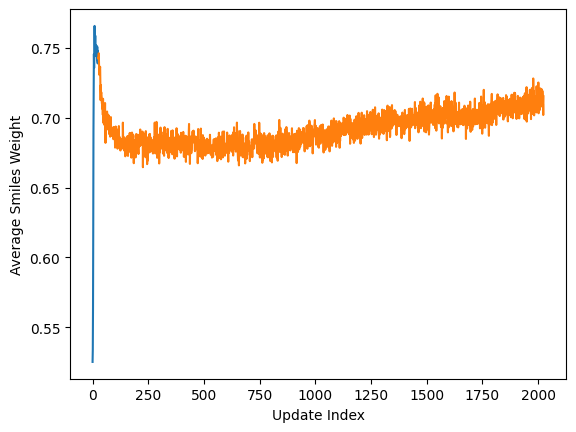

In [49]:
plt.plot(range(0, len(returned_stuff[-2])),returned_stuff[-2])
plt.plot(range(len(returned_stuff[-2]), len(returned_stuff[-2]) + len(returned_stuff1[-2])), returned_stuff1[-2])
plt.xlabel("Update Index")
# plt.xlim(0,100)
plt.ylabel("Average Smiles Weight")
plt.show()

In [50]:
returned_stuff_1_unr = np.array(returned_stuff[-1])
returned_stuff_2_unr = np.array(returned_stuff1[-1])

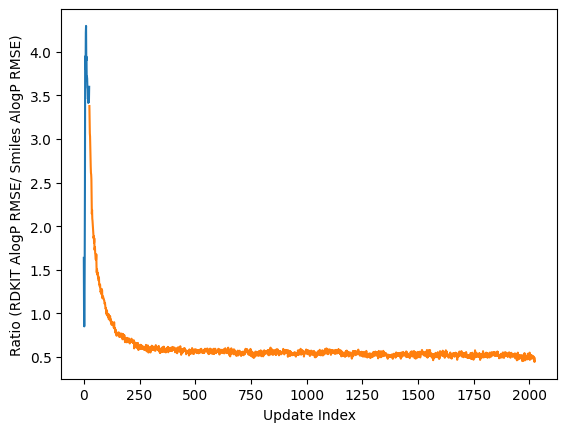

In [51]:
plt.plot(range(0, len(returned_stuff_1_unr)),returned_stuff_1_unr[:,0])
plt.plot(range(len(returned_stuff_1_unr), len(returned_stuff_1_unr) + len(returned_stuff_2_unr)), returned_stuff_2_unr[:,0])
plt.xlabel("Update Index")
plt.ylabel("Ratio (RDKIT AlogP RMSE/ Smiles AlogP RMSE)")
plt.show()

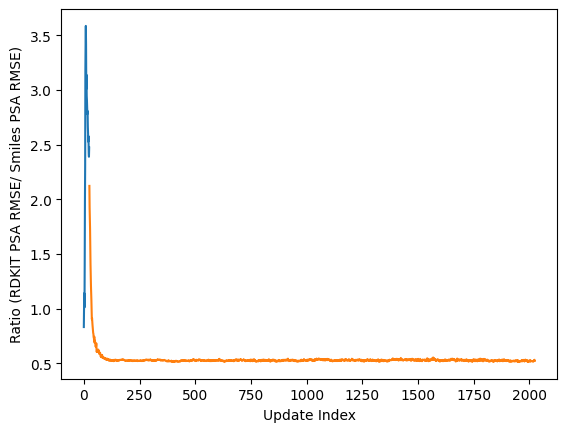

In [52]:
plt.plot(range(0, len(returned_stuff_1_unr)),returned_stuff_1_unr[:,1])
plt.plot(range(len(returned_stuff_1_unr), len(returned_stuff_1_unr) + len(returned_stuff_2_unr)), returned_stuff_2_unr[:,1])
plt.xlabel("Update Index")
plt.ylabel("Ratio (RDKIT PSA RMSE/ Smiles PSA RMSE)")
plt.show()

In [53]:
# returned_stuff1